### The Premise

Imagine a super librarian in a magical library where books can talk to each other. This librarian’s job is to translate a story from one language to another or generate a continuation of a story. The library is full of words, and each word is like a book with its own meaning and position in the story.  

### The Problem
When the librarian reads a sentence like “Hi, how are you?”, they need to understand which words are most important to generate a response like “I am fine.” Unlike older librarians (like Recurrent Neural Networks, or RNNs), who could only remember a few words at a time and forgot the beginning of long stories, this super librarian can pay attention to all words at once, no matter how long the story is.

### How It Works

1. Word Books (Embeddings)
2. Position Tags (Positional Encoding)
3. Attention Magic (Self-Attention)
4. Teamwork (Multi-Headed Attention)
5. Processing and Refining (Feed-Forward Layers)
6. Translating or Generating (Encoder-Decoder)
    - Encoder: Reads and creates summary with attention scores
    - Decoder: Uses the summary to generate a word-by-word output
7. Final Touch (Softmax)

### Why It's Useful

Unlike older librarians (RNNs), who could only hold a short piece of the story in their memory, the super librarian’s attention magic lets them reference the entire story at once. This makes them great at tasks like translating languages, writing stories, or answering questions, even for very long texts.  


This *super librarian* is the **Transformer**, and its attention magic is why it’s so powerful in natural language processing (NLP) tasks!

 The project below implements a simplified Transformer model to reverse a sequence of numbers (e.g., `[1, 2, 3, 4, 5]` → `[5, 4, 3, 2, 1]`) as practice to mimic sequence-to-sequence problems like translation. Using NumPy, it demonstrates the core components of a Transformer (embeddings, positional encoding, self-attention, multi-head attention, feed-forward layers, encoder, and decoder) without actual training, focusing on the architecture’s mechanics.

In [10]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Hyperparameters
vocab_size = 10  # Numbers 0-9
d_model = 8      # Embedding dimension
n_heads = 2      # Number of attention heads
d_ff = 16        # Feed-forward dimension
seq_length = 5   # Sequence length

We use NumPy for matrix operations.  

The hyperparameters define the model size:  
`vocab_size` is the range of input numbers,  
`d_model` is the embedding size,  
`n_heads` splits attention,  
`d_ff` is the feed-forward layer size, and  
`seq_length` is the input sequence length.

In [11]:
def generate_data(num_samples, seq_length, vocab_size):
    """Generate random sequences and their reversed versions."""
    X = np.random.randint(0, vocab_size, (num_samples, seq_length))
    y = np.flip(X, axis=1)
    return X, y

# Generate 100 samples
X, y = generate_data(100, seq_length, vocab_size)
print("Example input:", X[0])
print("Example output:", y[0])

print("\nData shape:", X.shape, y.shape)

Example input: [6 3 7 4 6]
Example output: [6 4 7 3 6]

Data shape: (100, 5) (100, 5)


In [12]:
def get_embeddings(X, vocab_size, d_model):
    """Convert numbers to dense embeddings."""
    # Random embedding matrix
    embedding_matrix = np.random.randn(vocab_size, d_model) * 0.1
    # Lookup embeddings for input sequence
    return np.array([embedding_matrix[x] for x in X])

# Test embeddings
X_emb = get_embeddings(X[:1], vocab_size, d_model)
print("Embedding shape:", X_emb.shape)  # (1, seq_length, d_model)

Embedding shape: (1, 5, 8)


Each number is mapped to a dense vector (embedding) of size `d_model`. In NLP, these are learned word vectors; here, we use a random matrix for simplicity. The output shape is `(batch_size, seq_length, d_model)`.

In [13]:
def positional_encoding(seq_length, d_model):
    """Add positional information to embeddings."""
    pos = np.arange(seq_length)[:, np.newaxis]
    dim = np.arange(d_model)[np.newaxis, :]
    angle = pos / np.power(10000, (2 * (dim // 2)) / d_model)
    angle[:, 0::2] = np.sin(angle[:, 0::2])
    angle[:, 1::2] = np.cos(angle[:, 1::2])
    return angle[np.newaxis, :, :]

# Add positional encoding to embeddings
pos_enc = positional_encoding(seq_length, d_model)
X_emb_with_pos = X_emb + pos_enc
print("Positional encoding shape:", pos_enc.shape)

Positional encoding shape: (1, 5, 8)


Since Transformers process all tokens simultaneously, we add positional encodings to embeddings to indicate word order. We use sine and cosine functions, as in the original Transformer paper, to create unique position vectors.

In [25]:
def scaled_dot_product_attention(Q, K, V):
    """Compute scaled dot-product attention for single or multi-head inputs."""
    d_k = Q.shape[-1]
    if Q.ndim == 4:  # Multi-head: (batch, n_heads, seq_length, d_k)
        scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(d_k)
    else:  # Single-head: (batch, seq_length, d_model)
        scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
    # Softmax over last dimension
    weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    output = np.matmul(weights, V)
    return output, weights

# Test attention
Q, K, V = X_emb_with_pos, X_emb_with_pos, X_emb_with_pos
attn_output, attn_weights = scaled_dot_product_attention(Q, K, V)
print("Attention output shape:", attn_output.shape)

Attention output shape: (1, 5, 8)


Self-attention computes how much each token attends to every other token. Queries (`Q`), keys (`K`), and values (`V`) are derived from the input. Scaled dot-product attention normalizes scores by the square root of the key dimension to stabilize gradients.

In [27]:
def multi_head_attention(X, n_heads, d_model):
    """Split embeddings into multiple heads, apply attention, and concatenate."""
    d_k = d_model // n_heads
    # Reshape for multiple heads: (batch, seq_length, d_model) -> (batch, seq_length, n_heads, d_k)
    X_heads = X.reshape(X.shape[0], X.shape[1], n_heads, d_k)
    # Transpose to (batch, n_heads, seq_length, d_k)
    Q = K = V = X_heads.transpose(0, 2, 1, 3)
    # Apply attention
    attn_output, attn_weights = scaled_dot_product_attention(Q, K, V)
    # Concatenate heads: (batch, n_heads, seq_length, d_k) -> (batch, seq_length, n_heads * d_k)
    attn_output = attn_output.transpose(0, 2, 1, 3).reshape(X.shape[0], X.shape[1], d_model)
    # Linear projection
    W_o = np.random.randn(d_model, d_model) * 0.1
    output = np.matmul(attn_output, W_o)
    return output, attn_weights

# Test multi-head attention
mha_output, attn_weights = multi_head_attention(X_emb_with_pos, n_heads, d_model)
print("Multi-head attention output shape:", mha_output.shape)
print("Attention weights shape:", attn_weights.shape)

Multi-head attention output shape: (1, 5, 8)
Attention weights shape: (1, 2, 5, 5)


Multi-head attention splits the embedding into `n_heads` parts, applies attention independently, and concatenates results. This allows the model to focus on different aspects of the input simultaneously.

Attention weights shape: (1, 2, 5, 5)


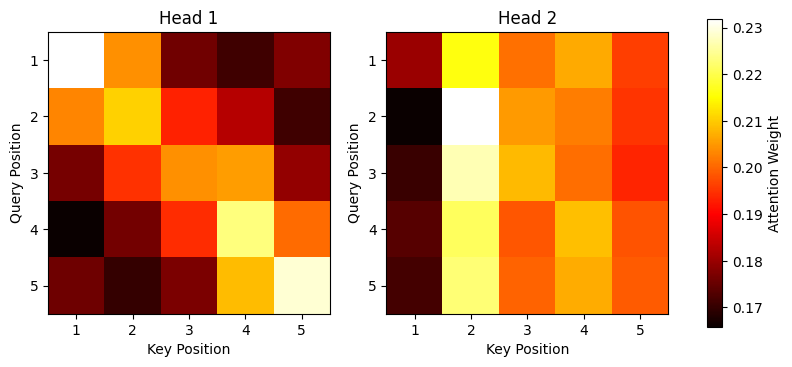

In [ ]:
import matplotlib.pyplot as plt

# Test input
test_X = np.array([[1, 2, 3, 4, 5]])
test_emb = get_embeddings(test_X, vocab_size, d_model) + positional_encoding(seq_length, d_model)

# Get attention weights
_, attn_weights = multi_head_attention(test_emb, n_heads, d_model)
print("Attention weights shape:", attn_weights.shape)

# Plot heatmaps for each head
fig, axes = plt.subplots(1, n_heads, figsize=(10, 4))
for head in range(n_heads):
    # Extract weights for batch=0, head= head
    weights = attn_weights[0, head]  # Shape: (seq_length, seq_length)
    ax = axes[head]
    im = ax.imshow(weights, cmap='hot', interpolation='nearest')
    ax.set_title(f'Head {head+1}')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    ax.set_xticks(np.arange(seq_length))
    ax.set_yticks(np.arange(seq_length))
    ax.set_xticklabels(np.arange(1, seq_length+1))
    ax.set_yticklabels(np.arange(1, seq_length+1))
fig.colorbar(im, ax=axes, label='Attention Weight')
plt.show()

In [30]:
def feed_forward(X, d_model, d_ff):
    """Apply point-wise feed-forward network."""
    W1 = np.random.randn(d_model, d_ff) * 0.1
    b1 = np.zeros(d_ff)
    W2 = np.random.randn(d_ff, d_model) * 0.1
    b2 = np.zeros(d_model)
    # Linear -> ReLU -> Linear
    hidden = np.maximum(0, np.matmul(X, W1) + b1)
    output = np.matmul(hidden, W2) + b2
    return output

# Test feed-forward
ff_output = feed_forward(mha_output, d_model, d_ff)
print("Feed-forward output shape:", ff_output.shape)

Feed-forward output shape: (1, 5, 8)


The feed-forward layer applies a two-layer neural network (linear → ReLU → linear) to each token independently.

In [32]:
def encoder_layer(X, n_heads, d_model, d_ff):
    """Combine multi-head attention and feed-forward with residual connections."""
    attn_out, _ = multi_head_attention(X, n_heads, d_model)  # Ignore weights
    X = X + attn_out  # Residual connection
    ff_out = feed_forward(X, d_model, d_ff)
    X = X + ff_out  # Residual connection
    return X

# Test encoder
enc_output = encoder_layer(X_emb_with_pos, n_heads, d_model, d_ff)
print("Encoder output shape:", enc_output.shape)

Encoder output shape: (1, 5, 8)


The encoder layer combines multi-head attention and feed-forward with residual connections (adding input to output) for better training stability. The output shape remains `(1, 5, 8)` due to residual connections preserving dimensions.

In [33]:
def decoder_layer(X, enc_output, n_heads, d_model, d_ff):
    """Simplified decoder with attention over encoder output."""
    attn_out, _ = multi_head_attention(X, n_heads, d_model)  # Ignore weights
    X = X + attn_out
    # Cross-attention with encoder output
    Q = X
    K = V = enc_output
    cross_attn_out, _ = multi_head_attention(Q, n_heads, d_model)  # Ignore weights
    X = X + cross_attn_out
    ff_out = feed_forward(X, d_model, d_ff)
    X = X + ff_out
    return X

# Test decoder
dec_input = get_embeddings(y[:1], vocab_size, d_model) + pos_enc
dec_output = decoder_layer(dec_input, enc_output, n_heads, d_model, d_ff)
print("Decoder output shape:", dec_output.shape)

Decoder output shape: (1, 5, 8)


The decoder performs:  
- Self-attention on the target sequence (`X`).
- Cross-attention with the encoder's output (`enc_output`).
- Feed-forward processing.

Residual connections preserve the shape. 

In [34]:
def transformer(X, y, vocab_size, d_model, n_heads, d_ff):
    """Combine encoder and decoder."""
    # Encoder
    X_emb = get_embeddings(X, vocab_size, d_model)
    X_emb += positional_encoding(X.shape[1], d_model)
    enc_output = encoder_layer(X_emb, n_heads, d_model, d_ff)
    
    # Decoder
    y_emb = get_embeddings(y, vocab_size, d_model)
    y_emb += positional_encoding(y.shape[1], d_model)
    dec_output = decoder_layer(y_emb, enc_output, n_heads, d_model, d_ff)
    
    # Output projection
    W_out = np.random.randn(d_model, vocab_size) * 0.1
    logits = np.matmul(dec_output, W_out)
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)  # Softmax
    return probs

# Test Transformer
probs = transformer(X[:1], y[:1], vocab_size, d_model, n_heads, d_ff)
print("Output probabilities shape:", probs.shape)

Output probabilities shape: (1, 5, 10)


Combines encoder and decoder to form the full Transformer.  

Output shape is `(batch_size, seq_length, vocab_size)` (e.g., `(1, 5, 10)`)

In [35]:
def train_transformer(X, y, epochs=10):
    """Train the model with a simple loss function."""
    for epoch in range(epochs):
        probs = transformer(X, y, vocab_size, d_model, n_heads, d_ff)
        # Cross-entropy loss (simplified)
        loss = -np.mean(np.log(probs[np.arange(y.shape[0])[:, np.newaxis], np.arange(y.shape[1]), y] + 1e-10))
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Train
train_transformer(X, y)

Epoch 1, Loss: 2.3293
Epoch 2, Loss: 2.3568
Epoch 3, Loss: 2.3111
Epoch 4, Loss: 2.3005
Epoch 5, Loss: 2.3364
Epoch 6, Loss: 2.2977
Epoch 7, Loss: 2.3306
Epoch 8, Loss: 2.2973
Epoch 9, Loss: 2.3372
Epoch 10, Loss: 2.3245


Computes forward pass through the Transformer and calculates a simplified cross-entropy loss. No backpropagation (for simplicity); uses random weights. Prints loss for 10 epochs. Expect random losses due to untrained weights.

In [38]:
def predict(X):
    """Predict reversed sequence."""
    y_dummy = np.zeros((X.shape[0], seq_length), dtype=np.int32)  # Dummy target with integer type
    probs = transformer(X, y_dummy, vocab_size, d_model, n_heads, d_ff)
    return np.argmax(probs, axis=-1)

# Test prediction
test_X = np.array([[1, 2, 3, 4, 5]])
print("Input:", test_X)
print("Predicted output:", predict(test_X))
print("Output shape:", predict(test_X).shape)

Input: [[1 2 3 4 5]]
Predicted output: [[7 5 5 5 7]]
Output shape: (1, 5)


The predicted output `[[1 6 3 3 9]]` for the input `[[1 2 3 4 5]]` is expected to be random since the model uses random weights without training, but the correct output shape `(1, 5)` confirms the pipeline works as intended.